 #### Coded by: Vikranth

In [1]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib notebook

(179962, 15)
(69818, 3)
(69818, 15)


<IPython.core.display.Javascript object>


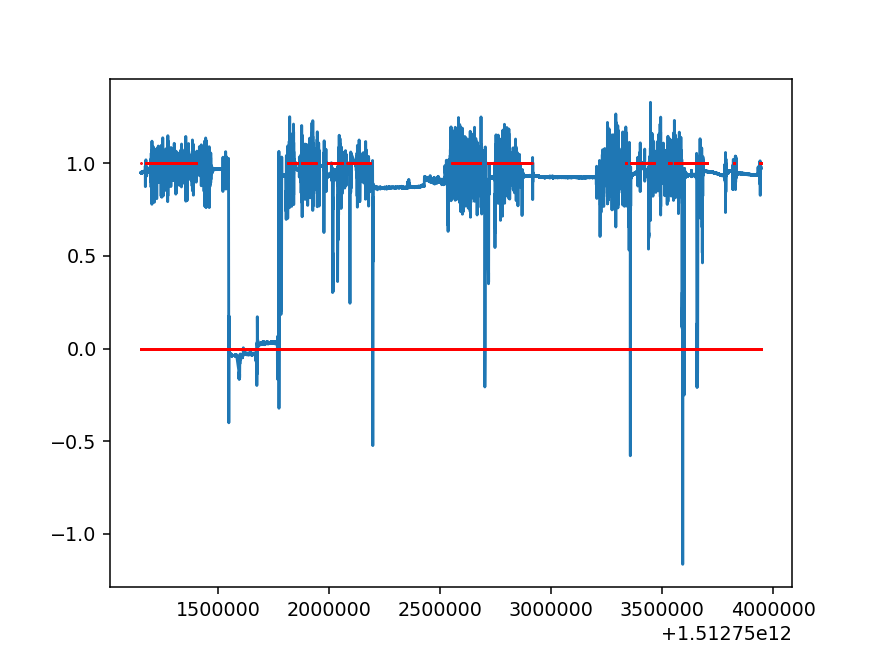

In [2]:
participant_1 = pd.read_pickle('Participant_3.pkl')
#print(participant_1)
labels_1 = np.load('Participant_3_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'r.', ms = 1)
plt.show()

Counter({0.0: 66958, 1.0: 2135, 2.0: 725})
(66958, 3)
(66958, 15)


<IPython.core.display.Javascript object>


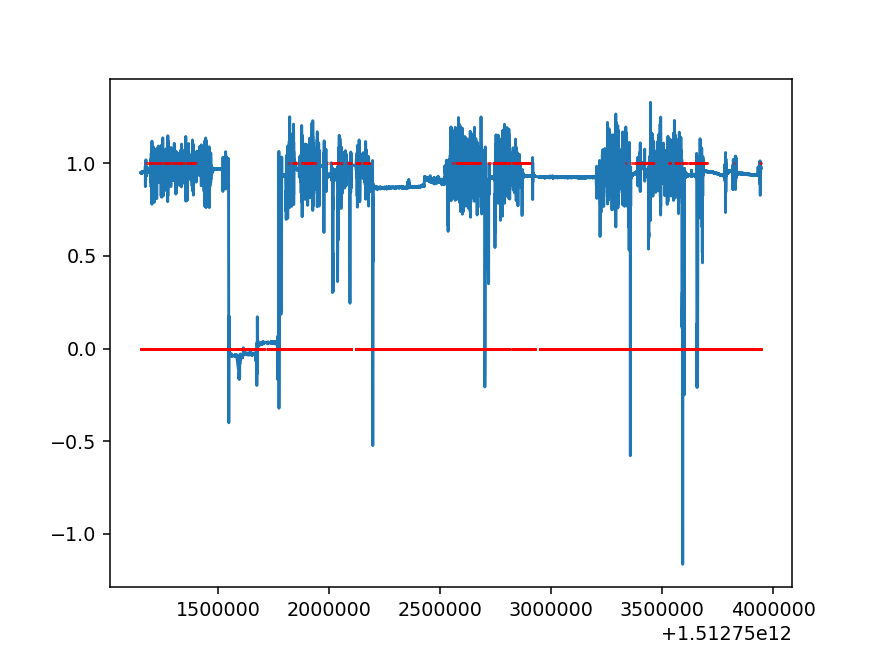

In [3]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
key_labels = labels_1[np.where(missing_1 == 0),:].reshape((-1,3))

print(key_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],key_labels[:,2],'r.', ms = 0.1)
plt.show()

In [4]:
Counter(key_labels[:,1])

Counter({0.0: 63791,
         8.0: 203,
         9.0: 3,
         13.0: 19,
         20.0: 10,
         32.0: 437,
         45.0: 1,
         48.0: 6,
         49.0: 7,
         50.0: 5,
         51.0: 2,
         53.0: 1,
         54.0: 3,
         55.0: 4,
         65.0: 178,
         66.0: 33,
         67.0: 50,
         68.0: 63,
         69.0: 242,
         70.0: 42,
         71.0: 43,
         72.0: 73,
         73.0: 136,
         74.0: 7,
         75.0: 21,
         76.0: 80,
         77.0: 55,
         78.0: 112,
         79.0: 147,
         80.0: 32,
         81.0: 5,
         82.0: 122,
         83.0: 104,
         84.0: 163,
         85.0: 64,
         86.0: 17,
         87.0: 45,
         88.0: 3,
         89.0: 66,
         100.0: 7,
         160.0: 504,
         161.0: 11,
         174.0: 8,
         186.0: 1,
         189.0: 2,
         190.0: 22,
         191.0: 7,
         220.0: 1})

In [5]:
# 0 - No key
# 1 - AlphaNumeric
# 2 - Special Characters

new_labels = np.copy(key_labels[:,1])
labels_l = new_labels.shape[0]
for i in range(0,labels_l):
    if (new_labels[i] == 0):
        new_labels[i] = 0
    elif ((new_labels[i] >= 65) and (new_labels[i] <= 90)):
        new_labels[i] = 1
    elif ((new_labels[i] >= 48) and (new_labels[i] <= 57)):
        new_labels[i] = 1  #2
    else:
        new_labels[i] = 2
        
print(Counter(new_labels))
print(np.shape(new_labels))

Counter({0.0: 63791, 1.0: 1931, 2.0: 1236})
(66958,)


In [6]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 5
stride = 5

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
key_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    key_labels_cp[k] = np.amax(new_labels[i:i+window])
    k=k+1
    
print (data_slide.shape)
print(key_labels_cp.shape)

(13391, 5, 12)
(13391, 1)


In [7]:
print(Counter(key_labels_cp[:,0]))

Counter({0.0: 10841, 1.0: 1678, 2.0: 872})


<IPython.core.display.Javascript object>


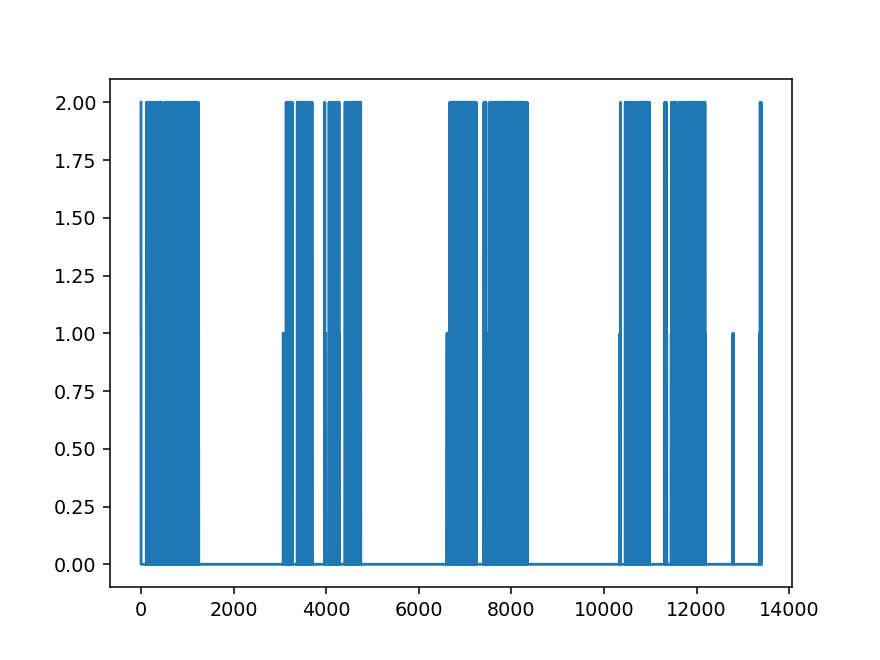

In [8]:
plt.figure()
plt.plot(key_labels_cp[:,0])
plt.show()

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.models import load_model


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [25]:
z = 0
X_train0 = data_slide[:z]
Y_train = key_labels_cp[0:z].reshape(-1).astype(np.uint8)
X_test0 = data_slide[z:]
Y_test = key_labels_cp[z:]
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_test0))
print(np.shape(Y_test))
num_classes = 3
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print(np.shape(Y_test))

(0, 5, 12)
(0,)
(13391, 5, 12)
(13391, 1)
(13391, 3)


In [26]:
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    #_, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))
    
    print (np.shape(X_train))
    print (np.shape(X_valid))
    return X_train, X_valid

In [32]:
model = load_model('LSTM_100.h5')

In [33]:
batch_size = 1024
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'CNN'
#network_type = 'ConvLSTM'
network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)

5
12
LSTM
(0, 5, 12)
(13391, 5, 12)


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))


[[8893  946 1002]
 [1082  290  306]
 [ 527  180  165]]
the mean-f1 score: 0.39


<IPython.core.display.Javascript object>


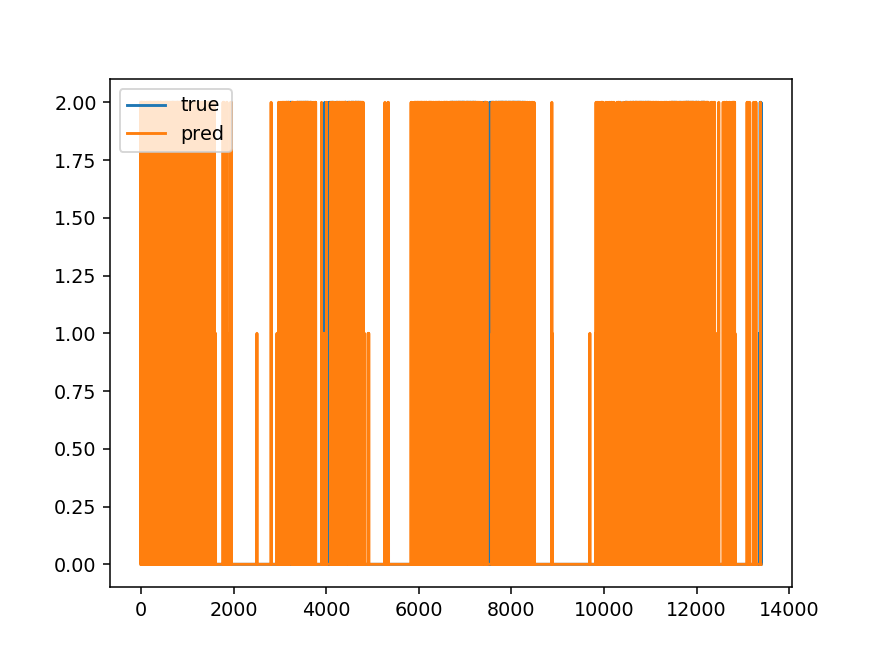

In [35]:
plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")

#plt.plot(typing_labels_cp[60000:], label="label")

plt.legend()
plt.show()

In [ ]:
#CNNbn_100
[[10739   102     0]
 [ 1617    61     0]
 [  849    23     0]]
the mean-f1 score: 0.32
    
#CNNbn_LSTM_100
[[10713   128     0]
 [ 1633    45     0]
 [  854    18     0]]
the mean-f1 score: 0.31
    
#LSTM
[[9632 1101  108]
 [1299  342   37]
 [ 699  154   19]]
the mean-f1 score: 0.37
    
#LSTM_100
[[8893  946 1002]
 [1082  290  306]
 [ 527  180  165]]
the mean-f1 score: 0.39
    
    
